In [1]:
from em_functions import *
import matplotlib.pyplot as plt
import time
import multiprocess as mp
# from labellines import labelLine, labelLines

In [2]:
nprocs = mp.cpu_count()
pool = mp.Pool(processes=nprocs)

# Full Monte Carlo
def find_sol(emparams, rparams):
    ri, rf, dr = rparams
    steps = int((rf - ri)//dr)

    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    count, step_stdev, nneighboors = 0, 1, nprocs
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        allphi0s = np.array([phi0]*nneighboors) + np.random.normal(0,step_stdev,nneighboors)

        mcs = pool.starmap(mc_step, [(phi0here, bpoint, emparams, rparams) for phi0here in allphi0s])
        bpoints = np.array([mc[1] for mc in mcs])
        bpoint_max = np.amax(bpoints)
        index_max = np.where(bpoints == bpoint_max)[0]

        if bpoint_max > bpoint:  # If a larger 'bpoint' is found, keep
            bpoint = bpoint_max
            phi0 = allphi0s[index_max][0]
        else:   # If not, back to old valur of phi0
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 2:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

The value of epsilonb is: 0.6233710381499736
The value of tilde phi0 is: -0.593488949674398


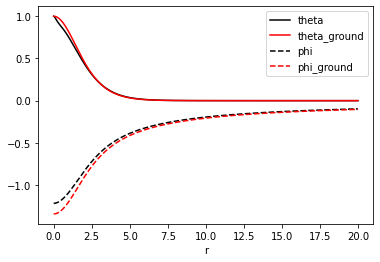

In [31]:
# Plotting solution
rparams = 0, 20, 0.01 # rparams in the format ri, rf, dr
ri, rf, dr = rparams
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

emparams = [10, 0, 0.1] # emparams in the format [scale, center, size]
phi0_plt = find_sol(emparams, rparams)[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt, emparams, rparams)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

# emparams_ref = [0, 0, 0.1] # emparams in the format [scale, center, size]
# phi0_ref = find_sol(emparams_ref, rparams)[0]
# Xbc_ref = np.array([1, 0, phi0_ref, 0])
# Xs_ref, bpoint_ref = rk4(Xbc_ref, emparams_ref, rparams)
# rinterv_cut_ref, Xs_ref = rinterv[:bpoint], Xs_ref[:, :bpoint]

Xs_readflat = np.loadtxt("output/hr_ground.txt")
rinterv_read = np.linspace(ri, rf, int(len(Xs_readflat)/4), endpoint=True)
Xs_read = Xs_readflat.reshape(4, int(len(Xs_readflat)/4))
# Xs_ground = Xs_read[0].T
# Xs_only, Xs_ground = Xs[0].T, Xs_ref[0].T
# max_ind = np.max([bpoint, bpoint_ref])

# Xs = rescaled_asymp(Xs, bpoint, rparams)*Xs


epsilonb_read = find_epsilonb(rinterv_read, Xs_read)[0]
epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is:', epsilonb)
print('The value of tilde phi0 is:', Xs[2].T[0])

plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_read, Xs_read[0].T, 'r', label = "theta_ground")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.plot(rinterv_read, Xs_read[2].T - epsilonb_read, 'r--', label = "phi_ground")
plt.xlabel("r")
plt.legend();

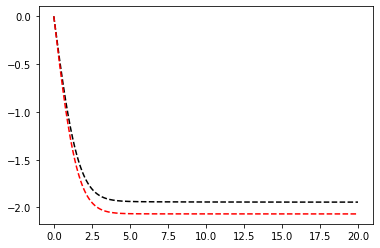

In [32]:
plt.plot(rinterv_cut, (Xs[2].T - epsilonb)*rinterv_cut, 'k--', label = "phi")
plt.plot(rinterv_read, (Xs_read[2].T - epsilonb_read)*rinterv_read, 'r--', label = "phi_ground")
# plt.xlim(left = 10, right = 20)
# plt.ylim(top = 0, bottom = -0.2)

In [80]:
# Finding solutions, emparams in the format [scale = 1, center = 0, size = 0.1]
scales = np.linspace(0, 100, 101, endpoint=True)[1:]
size_choice = 0.01

start_time = time.time()
thetas, phis, epsilonbs = [], [], []
for scale in scales:
    emparams = [scale, 0, size_choice]
    phi0_plt = find_sol(emparams)[0]
    Xbc_plt = np.array([1, 0, phi0_plt, 0])
    Xs, bpoint = rk4(Xbc_plt, emparams)
    rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

    thetas.append(np.array(list(zip(rinterv_cut, Xs[0].T))))
    phis.append(np.array(list(zip(rinterv_cut, Xs[2].T))))

    epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
    epsilonbs.append(epsilonb)
    print('Found solution for emparams = ', emparams, '. It took ', np.round((time.time() - start_time)/60, 2), ' minutes.')
    start_time = time.time()

Found solution for emparams =  [1.0, 0, 0.01] . It took  20.23  minutes.
Found solution for emparams =  [2.0, 0, 0.01] . It took  20.25  minutes.
Found solution for emparams =  [3.0, 0, 0.01] . It took  20.56  minutes.
Found solution for emparams =  [4.0, 0, 0.01] . It took  20.51  minutes.
Found solution for emparams =  [5.0, 0, 0.01] . It took  20.43  minutes.
Found solution for emparams =  [6.0, 0, 0.01] . It took  20.57  minutes.
Found solution for emparams =  [7.0, 0, 0.01] . It took  21.57  minutes.
Found solution for emparams =  [8.0, 0, 0.01] . It took  20.15  minutes.
Found solution for emparams =  [9.0, 0, 0.01] . It took  19.77  minutes.
Found solution for emparams =  [10.0, 0, 0.01] . It took  19.81  minutes.
Found solution for emparams =  [11.0, 0, 0.01] . It took  19.72  minutes.
Found solution for emparams =  [12.0, 0, 0.01] . It took  19.8  minutes.
Found solution for emparams =  [13.0, 0, 0.01] . It took  19.74  minutes.
Found solution for emparams =  [14.0, 0, 0.01] .

KeyboardInterrupt: 

In [88]:
# Save data
np.savez("output/bump_s_0_0dot01.npz", phis = phis, thetas = thetas, epsilonbs = epsilonbs, scales = scales)

# Load saved data
data = np.load("output/bump_s_0_0dot01.npz", allow_pickle=True)
thetas, phis, epsilonbs, scales = data['thetas'], data['phis'], data['epsilonbs'], data['scales']

C:\Users\gsali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


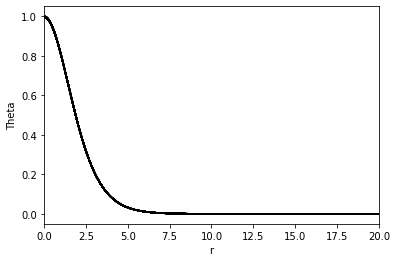

In [89]:
# Plotting the solutions
for i, theta in enumerate(thetas):
    if scales[i] == 0:
        plt.plot(theta.T[0], theta.T[1], color = 'red', label = str(scales[i]))
    else:
        plt.plot(theta.T[0], theta.T[1], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Theta')
plt.xlim(left = 0, right = 20);

# xvals = []
# labelLines(plt.gca().get_lines(),  align=False);

Text(0, 0.5, 'epsilonb')

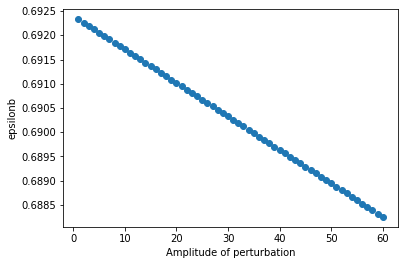

In [90]:
plt.scatter(scales[:60],epsilonbs)
plt.xlabel('Amplitude of perturbation')
plt.ylabel('epsilonb')

Text(0, 0.5, 'Phi')

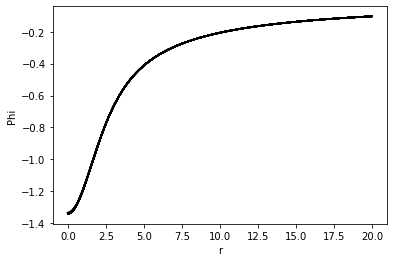

In [91]:
# Plotting the potentials, emparams in the format [scale, center = 0, size = 1]
for i, phi in enumerate(phis):
    plt.plot(phi.T[0], phi.T[1] - epsilonbs[i], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Phi')

# xvals = [1,1,1,1]
# labelLines(plt.gca().get_lines(), xvals = xvals, align=False);